In [5]:
using JuMP, Gurobi, Ipopt,AmplNLWriter, NLopt
using Mosek, Cbc
    k = 4              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(2,k)    # vector of waypoint locations

    T[1] = 1
    T[2] = 20
    T[3] = 50
    T[4] = 60

    # define waypoints
    xw = [ 1   4   6   1
           1   3   0   1 ]

   # Obstacle at 3,3 as center with length and breadth of 1.
   # x >= 2.5
   # x <= 3.5
   # y >= 2.5
   # y <= 3.5
   A = [1 0;
        -1 0;
        0 1;
        0 -1;]
   b = [2.5; -3.5; 2.5; -3.5]

4-element Array{Float64,1}:
  2.5
 -3.5
  2.5
 -3.5

In [6]:
    m = Model(solver = GurobiSolver(OutputFlag=0))
    #m = Model(solver=AmplNLSolver("bonmin"))
    #m = Model(solver=AmplNLSolver("couenne"))
    #m = Model(solver=CbcSolver())
    #m = Model(solver=NLoptSolver(algorithm=:LD_MMA))
    #m = Model(solver=IpoptSolver())
    @variable(m, x[1:2,1:T[k]])  # resulting position
    @variable(m, v[1:2,1:T[k]])  # resulting velocity
    @variable(m, u[1:2,1:T[k]])  # thruster input
    @variable(m, obstacle[1:4,1:T[k]], Bin)

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== [0;0])

    for t in 1:T[k]-1
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[:,t+1] .== v[:,t] + u[:,t])
    end

    for t in 1:T[k]-1
        @constraint(m, A*x[:,t] .<= b .+ 1000*obstacle[:,t])
        #@constraint(m, (x[1,t]) <= 2.5 + 1000*obstacle[1,t])
        #@constraint(m, -(x[1,t]) <= -3.5 + 1000*obstacle[2,t])
        #@constraint(m, (x[2,t]) <= 2.5 + 1000*obstacle[3,t])
        #@constraint(m, -(x[2,t]) <= -3.5 + 1000*obstacle[4,t])
        @constraint(m, sum(obstacle[i,t] for i in 1:4) <= 3)
    end

    @expression(m,distanceTravelled, sum(sum((x[:,t+1] - x[:,t]).^2) for t in 1:T[k]-1))
    # hit all the waypoints
    for i in [1 k]
        @constraint(m, x[:,T[i]] .== xw[:,i])
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    λ = 100
    β = .1
    @objective(m, Min, sum(u.^2) + λ*sum( (x[:,T[2:k]]-xw[:,2:k]).^2  ) + β*distanceTravelled)
    solve(m)
    
    xopt = getvalue(x)
    obstacleOpt = getvalue(obstacle)
    println(getobjectivevalue(m))
    #m

0.49030051290264964


In [7]:
println(obstacleOpt[:,5])
println(xopt[:,5])
println(getvalue(distanceTravelled))

[0.0,1.0,0.0,1.0]
[1.29104,1.17089]
4.134787050457913


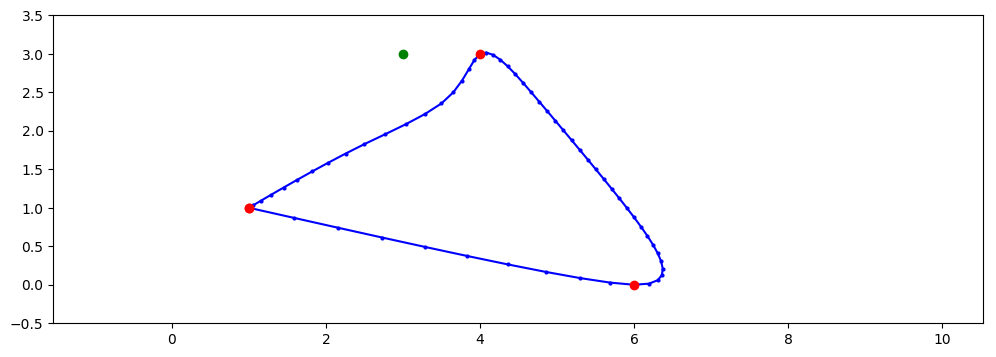

In [8]:
using PyPlot
figure(figsize=(12,4))
plot( xopt[1,:][:], xopt[2,:][:], "b.-", markersize=4 )
plot( xw[1,:], xw[2,:], "r.", markersize=12 )
plot( 3, 3, "g.", markersize=12 )
axis("equal")
axis((1.,8.,-.5,3.5));